# Overview

This notebook documents my feature engineering process.<br>
It answers my questions from exploration and gives me a better understanding of the dataset.

The content includes:

1. Handle missing values

2. Investigate and transform DateTime columns

3. Add features that could describe customers' or merchants' behavior

Thank you for taking your time to go through my work.

In [1]:
# Import packages
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Setup display
pd.options.display.max_rows = 999
pd.options.display.max_columns = 50

In [2]:
file = pd.read_pickle('./data.pkl')

As the dataset is **highly imbalanced**, I will try to keep all the positive cases in the pre-processing period.

In [3]:
print('Minority class takes up', round(len(file[file.isFraud==True])/len(file)*100,2),'% in this dataset, and',round(file[file.isFraud==True]['transactionAmount'].sum()/file.transactionAmount.sum()*100,2),'% in values.')

Minority class takes up 1.58 % in this dataset, and 2.6 % in values.


## Missing values
Techniques used here:
1. Binarization
2. Add unknown value to a new category
3. Imputation
4. Remove when it is hard to infer and takes up only a very small amount of data

In [4]:
def check_distribution(col):
    global file
    display(file.groupby([col])['transactionAmount'].count())
    false,true = file[file[col].isna()].groupby('isFraud')['transactionAmount'].count().values
    if true/(false+true) > 0.0158: print('True')
    return None

In [5]:
col = 'acqCountry'
check_distribution(col)

acqCountry
CAN      2424
MEX      3130
PR       1538
US     774709
Name: transactionAmount, dtype: int64

True


Keep it since it can provide some information. **Combine** the non-US countries together as they are minority classes.

In [6]:
file[col] = file[col].apply(lambda x: 1 if x == 'US' else 0)

In [7]:
col = 'merchantCountryCode'
check_distribution(col)

merchantCountryCode
CAN      2426
MEX      3143
PR       1559
US     778511
Name: transactionAmount, dtype: int64

True


Missings' part has a lot of positive values. **Combine** non-US labels, add null as a **new** category.

In [8]:
file[col].fillna(0, inplace=True)
file[col] = file[col].apply(lambda x: 1 if x == 'US' else (x if x==0 else 2))

In [9]:
col = 'posEntryMode'
check_distribution(col)

posEntryMode
02    195934
05    315035
09    236481
80     15283
90     19576
Name: transactionAmount, dtype: int64

True


Add as a **new** category.

In [10]:
file[col].fillna(0, inplace=True)

In [11]:
col = 'posConditionCode'
check_distribution('posConditionCode')

posConditionCode
01    628787
08    149634
99      7533
Name: transactionAmount, dtype: int64

True


**Impute** as existing category 99, according to https://www.mreports.com/documentation/ac/nonmerchant/80449.htm there is no code 99, they might also be invalid.

In [12]:
file[col].fillna('99', inplace=True)

In [13]:
col = 'transactionType'
check_distribution('transactionType')

transactionType
ADDRESS_VERIFICATION     20169
PURCHASE                745193
REVERSAL                 20303
Name: transactionAmount, dtype: int64

True


It's a little hard to infer these transactions, as in the previous sections. I decide to **drop** this one.

In [14]:
file.drop(file[file[col].isna()].index, axis=0, inplace=True)

## Investigate datetime columns

In [15]:
datetime_columns = ['currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange']
for col in datetime_columns:
    file[col] = pd.to_datetime(file[col])
file.dtypes

accountNumber                         int64
creditLimit                           int64
availableMoney                      float64
transactionDateTime          datetime64[ns]
transactionAmount                   float64
merchantName                         object
acqCountry                            int64
merchantCountryCode                   int64
posEntryMode                         object
posConditionCode                     object
merchantCategoryCode                 object
currentExpDate               datetime64[ns]
accountOpenDate              datetime64[ns]
dateOfLastAddressChange      datetime64[ns]
cardCVV                               int64
enteredCVV                            int64
cardLast4Digits                       int64
transactionType                      object
currentBalance                      float64
cardPresent                            bool
expirationDateKeyInMatch               bool
isFraud                                bool
lastTransaction             time

In [16]:
'''
daysSinceOpen: Days since account open

daysExpired: Days left before expire

daysSinceAddressChange: Days since address change

timeOfDay: devide 24 hours into 6 parts
'''

file['daysSinceOpen'] = (file.transactionDateTime - file.accountOpenDate).dt.days.astype(int)

file['daysExpired'] = (file.currentExpDate - file.transactionDateTime).dt.days.astype(int)

file['daysSinceAddressChange'] = (file.transactionDateTime - file.dateOfLastAddressChange).dt.days.astype(int)

file["timeOfDay"] = pd.cut(file.transactionDateTime.dt.hour, bins=6, labels=list(range(6)))


In [17]:
file.drop(columns=datetime_columns, inplace=True)
file.reset_index(inplace=True, drop=True)

## Add Features That Could Capture Customers' or Merchants' Behavior

In this part, I think one important thing is to not introduce **information leak** to the model. 

So I try to avoid using **future records** to build the features(for example, **overall mean** of fraud that happened in the account on day1). Instead, I used **cumulative values**.

With that in mind, I design the features to depict a customers' **long-term pattern**, like favorite merchants, past fraud records, and **short-term behavior**, such as current daily spending and if it is a frequent transaction.

#### New Features

**CVVMatch**: Boolean values. True if input CVV matched with card CVV.
<br>**transactionDate**: Categorical feature. Time of day the transaction happened.
<br>**dailySpend**: Continuous feature. Money already spend that day (before current transaction).
<br>**pastFraudInAccount**: Ordinal feature. Number of past fraud associated with this account.
<br>**pastVisitsToMerchant**: Ordinal feature. Number of past visits to this merchant associated with this account.
<br>**multiSwipe**: Boolean values. Identified in Part 3.
<br>**frequentiTransactions**: Boolean values. True if last transaction happened within 10 minutes.
<br>**missingCardNumber**: Boolean values. Fields in cardLast4Digits sometimes are not a 4-digit number.

In [18]:
file['CVVMatch'] = file['cardCVV'] == file['enteredCVV']

file['transactionDate'] = file.transactionDateTime.dt.to_period(freq='D')

file['dailySpend'] = file.sort_values(['accountNumber','transactionDate']).groupby(['accountNumber','transactionDate'])['transactionAmount'].cumsum()

file['pastFraudInAccount'] = file.sort_values(['accountNumber', 'transactionDate']).groupby('accountNumber')['isFraud'].cumsum()

file['pastVisitsToMerchant'] = file.groupby(['accountNumber','merchantName'])['transactionDateTime'].cumcount()

file['pastFraudInMerchant'] = file.sort_values(['merchantName', 'transactionDate'], ascending=True)[['merchantName','isFraud']].groupby('merchantName').cumsum().sort_index()

file['multiSwipe'] = ((file[['accountNumber', 'merchantName', 'transactionAmount', 'cardLast4Digits']].duplicated())
                      & (file.lastTransaction < timedelta(hours=1)) 
                      & (file.transactionType=='PURCHASE'))

file['frequentTransactions'] = (file['transactionDateTime'] - file.groupby('accountNumber')['transactionDateTime'].shift(1)) < timedelta(minutes=10)

file['missingCardNumber'] = file.cardLast4Digits.apply(lambda x: True if len(str(x))!=4 else False)


In [19]:
file.drop(columns=['cardCVV', 'enteredCVV', 'transactionDate', 'lastTransaction'], inplace=True)

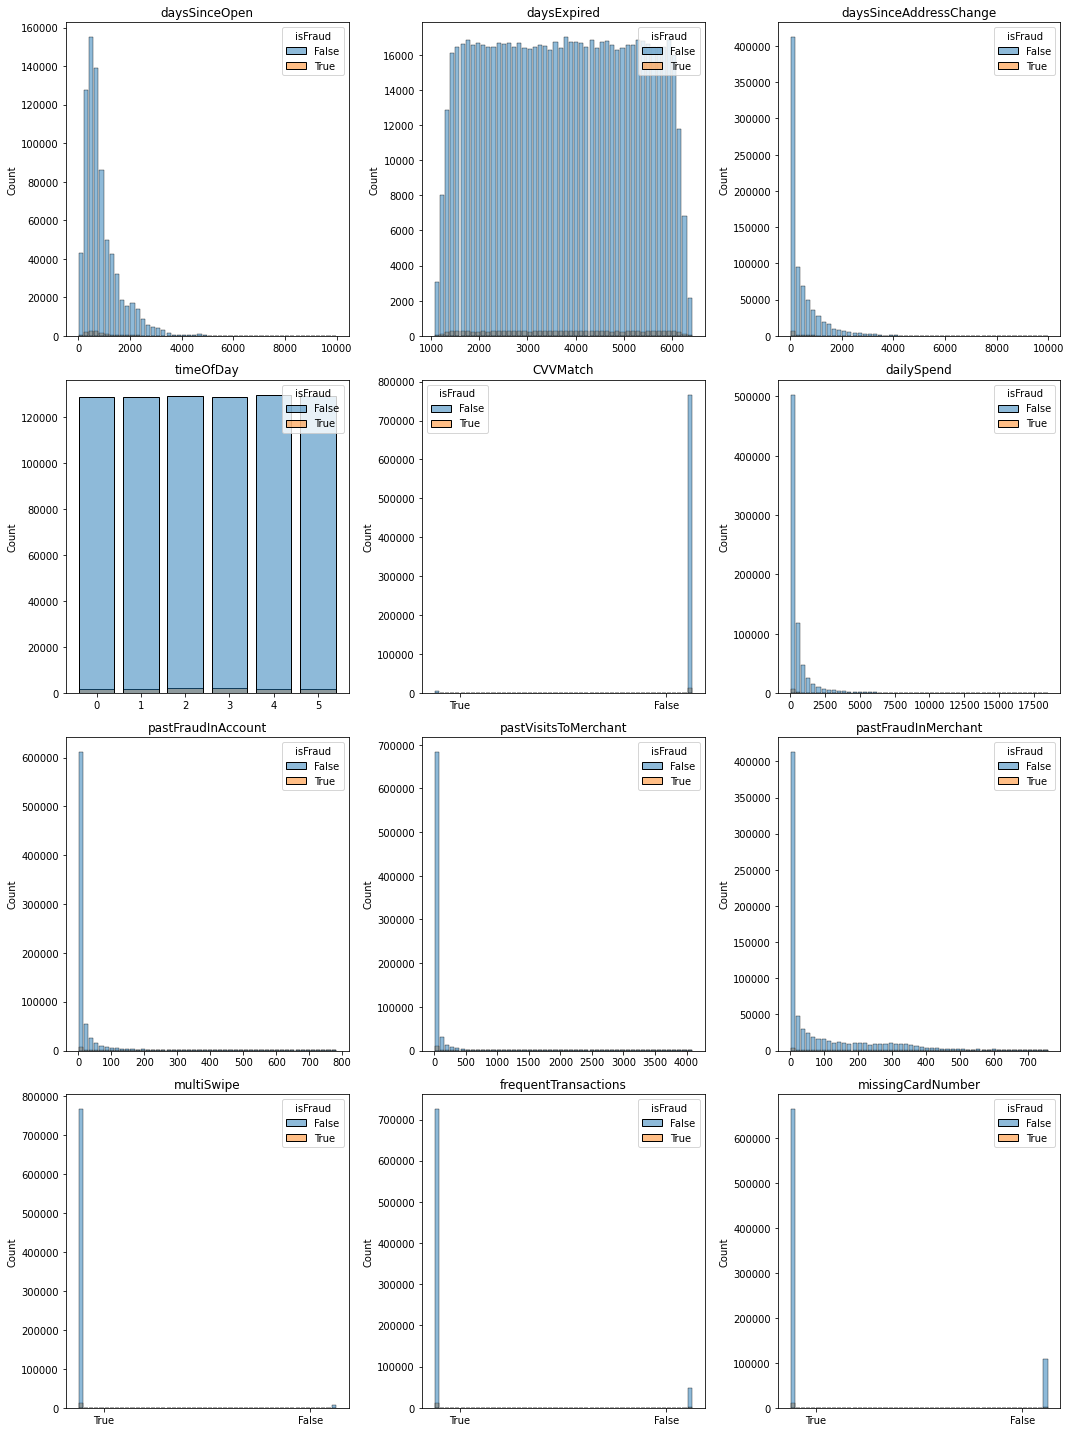

In [20]:
# Take a look at the distribution of newly-added features

features_of_interest = file.columns[17:]

i, j = 0, 0
rows = 3
fig, axes = plt.subplots(round(len(features_of_interest)/rows), rows, figsize = (15, 20))
for col in features_of_interest:

    sns.histplot(data=file, x=col, bins = 50, hue = 'isFraud',
                 ax = axes[i,j], shrink = 0.8, alpha = 0.5) # color= '#c5cff0', 
    axes[i,j].set_xlabel('')
    axes[i,j].set_title(col)

    if file[col].nunique() == 2:
        axes[i,j].set_xticks([0.1,0.9])
        axes[i,j].set_xticklabels(['True', 'False'])

    if j == rows-1: 
        i += 1
        j = 0
    else: 
        j += 1

plt.tight_layout()
plt.show()

Most of the continuous variabels need to be normlized. 

## Feature Summary

**Continuous variables**:
* currentBalance
* availableMoney
* transactionAmount
* dailySpend
* daysSinceOpen
* daysExpired
* daysSinceAddressChange
* pastFraudInAccount
* pastVisitsToMerchant
* pastFraudInMerchant

**Categorical variables**:
* acqCountry
* creditLimit
* merchantCategoryCode
* merchantCountryCode
* posEntryMode
* posConditionCode
* transactionType
* cardPresent
* expirationDateKeyInMatch
* timeOfDay
* CVVMatch
* multiSwipe
* frequentTransactions
* missingCardNumber

**Target variable**:
* isFraud


In [21]:
pd.to_pickle(file, 'data.pkl')